In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

In [2]:
raw_text = open('../outs/strat_eval.txt', 'r').read()

In [3]:
prop_mapping = {
    'Strategy 1': 'V Gr',
    'Strategy 2': 'Gr',
    'Strategy 3': 'F',
    'Strategy 4': 'Ge',
    'Strategy 5': 'V Ge',
    'Strategy 6': 'Other',
}

resp_mapping = {
    'Strategy 1': 'AC Fav.',
    'Strategy 2': 'AC Fair',
    'Strategy 3': 'AC Un.',
    'Strategy 4': 'R Fav.',
    'Strategy 5': 'R Fair',
    'Strategy 6': 'R Un.',
    'Strategy 7': 'Other',
}

data_rows = []
current_role = None

# Using io.StringIO to simulate file reading from the string above
for line in raw_text.split('\n'):
    line = line.strip()
    if line.startswith("--- Analyzing"):
        current_role = line.split()[2].replace("---", "")
        continue
    
    # Parse lines starting with [group]
    if line.startswith("["):
        # Split by multiple spaces to separate columns
        parts = [p.strip() for p in line.split('    ') if p.strip()]
        
        # Robust check to ensure we have enough parts parsed
        if len(parts) < 2: 
            continue

        # Extract strategy and belief
        # part[0] looks like "[fair] Strategy 1 vs Strategy 3"
        try:
            bracket_split = parts[0].split('] ')
            belief = bracket_split[0].replace('[', '')
            strats = bracket_split[1]
            
            strat1, strat2 = strats.split(' vs ')
        except IndexError:
            continue
        
        # Map strategy names
        if current_role == 'Proposer':
            strat1 = prop_mapping.get(strat1, strat1)
            strat2 = prop_mapping.get(strat2, strat2)
        elif current_role in ['Responder_Accept', 'Responder_Reject']:
            strat1 = resp_mapping.get(strat1, strat1)
            strat2 = resp_mapping.get(strat2, strat2)

        # Parse numbers (handling the fact that some lines might be broken in original text)
        # We assume the last two are CIs and the second item is Coef
        try:
            coef = float(parts[1])
            ci_lower = float(parts[-2])
            ci_upper = float(parts[-1])
        except ValueError:
            continue

        data_rows.append({
            'Role': current_role,
            'Belief': belief,
            'Comparison': f"{strat1} vs\n{strat2}",
            'Coef': coef,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper
        })

df = pd.DataFrame(data_rows)

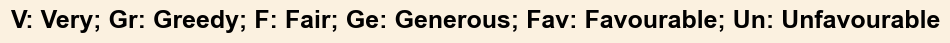

In [15]:
fig_mapping, ax_mapping = plt.subplots(figsize=(8, 0.3))
ax_mapping.axis('off')

mapping_text = "V: Very; Gr: Greedy; F: Fair; Ge: Generous; Fav: Favourable; Un: Unfavourable"

ax_mapping.text(0.5, 0.5, mapping_text, 
                transform=ax_mapping.transAxes,
                fontsize=18, fontweight='bold',
                va='center', ha='center',
                bbox=dict(boxstyle='round,pad=1.0', facecolor='wheat', alpha=0.4, edgecolor='gray', linewidth=1.5),)

plt.savefig('../plots/keyword_mapping.pdf', dpi=500, bbox_inches='tight')
# plt.show()

In [5]:
# plt.rcParams.update(plt.rcParamsDefault)

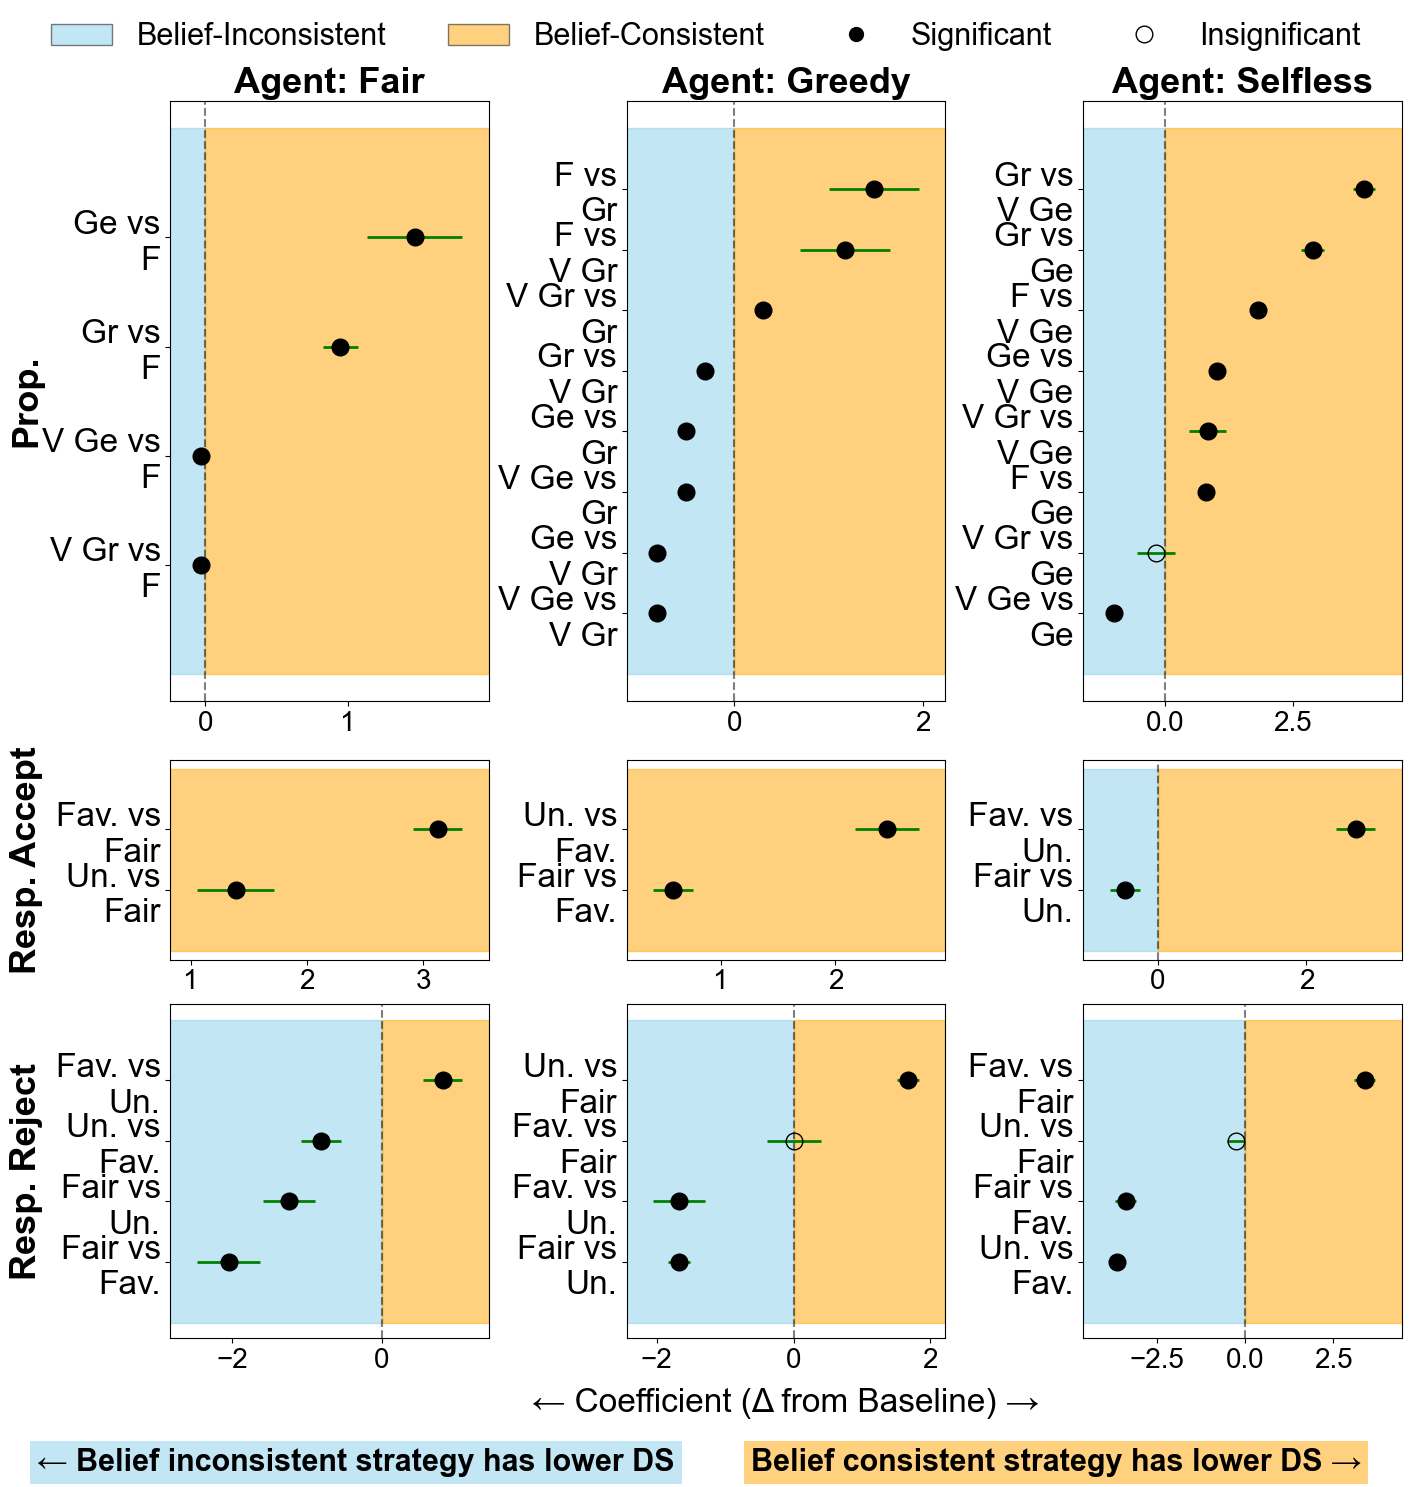

In [4]:
# ---------------------------------------------------------
# Plotting with Transposed Forest Plots (Comparisons on Y-axis)
# ---------------------------------------------------------

rows_order = ['Proposer', 'Responder_Accept', 'Responder_Reject']
cols_order = ['fair', 'greedy', 'selfless']

row_heights = [9, 3, 5]

tex_role_mapping = {
    'Proposer': r'$P$',
    'Responder_Accept': r'$R^A$',
    'Responder_Reject': r'$R^R$'
}

role_mapping = {
    'Proposer': 'Prop.',
    'Responder_Accept': 'Resp. Accept',
    'Responder_Reject': 'Resp. Reject'
}

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial"
})

# --- Create Subplots ---
fig, axes = plt.subplots(
    nrows=3, ncols=3, 
    figsize=(14, sum(row_heights)*0.8),
    constrained_layout=True,
    gridspec_kw={'height_ratios': row_heights}
)

for row_idx, role in enumerate(rows_order):
    for col_idx, belief in enumerate(cols_order):
        ax = axes[row_idx, col_idx]
        
        significant_subset = df[(df['Role'] == role) & (df['Belief'] == belief)].sort_values(by='Coef').reset_index(drop=True)

        if significant_subset.empty:
            ax.text(0.5, 0.5, 'No significant results', transform=ax.transAxes, ha='center', va='center')
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            # We determine how many items we are actually going to plot based on your logic
            # To keep indexing clean, we'll filter the dataframe first
            mask = []
            for _, row_data in significant_subset.iterrows():
                if (row_data['Role'] == 'Responder_Accept' and row_data['Comparison'].split()[0] == 'AC') or \
                   (row_data['Role'] == 'Responder_Reject' and row_data['Comparison'].split()[0] == 'R') or \
                   (row_data['Role'] == 'Proposer'):
                    mask.append(True)
                else:
                    mask.append(False)
            
            plot_df = significant_subset[mask].reset_index(drop=True)
            y_pos = range(len(plot_df))
            
            # Reference line at Coef = 0
            ax.axvline(0, color='black', linestyle='--', alpha=0.5)

            # --- SWAP: Set X limits based on Coef and CI ---
            x_min = plot_df['CI_Lower'].min()
            x_max = plot_df['CI_Upper'].max()
            pad = (x_max - x_min) * 0.1 if x_max != x_min else 1.0
            ax.set_xlim(x_min - pad, x_max + pad)
            current_xlim = ax.get_xlim()

            # --- SWAP: Background zones (now horizontal) ---
            # Shading the background along the X-axis
            ax.fill_between([current_xlim[0], 0], -1, len(plot_df), color='skyblue', alpha=0.5)
            ax.fill_between([0, current_xlim[1]], -1, len(plot_df), color='orange', alpha=0.5)

            # --- SWAP: Draw Horizontal Forest Plot ---
            for y, (_, row_data) in zip(y_pos, plot_df.iterrows()):
                # hlines(y, xmin, xmax)
                ax.hlines(y, row_data['CI_Lower'], row_data['CI_Upper'], color='green', lw=2)
                
                if row_data['CI_Lower'] > 0 or row_data['CI_Upper'] < 0:
                    ax.plot(row_data['Coef'], y, 'o', color='black', markersize=12)
                else:
                    ax.plot(row_data['Coef'], y, 'o', color='black', markersize=12, mfc='none', mec='black')

            # --- SWAP: Labels on Y-axis ---
            ax.set_yticks(y_pos)
            clean_labels = [i.replace('AC ', '').replace('R ', '') for i in plot_df['Comparison']]
            ax.set_yticklabels(clean_labels, fontsize=24)

            ax.tick_params(axis='x', labelsize=20)

        if row_idx == 0:
            ax.set_title(f"Agent: {belief.capitalize()}", fontsize=26, fontweight='bold')
        
        # Bottom row gets the X-axis label
        if row_idx == 2 and col_idx == 1:
            ax.set_xlabel("← Coefficient (Δ from Baseline) →", fontsize=24, labelpad=10)

        # Left column gets the Role labels
        if col_idx == 0:
            ax.text(-0.4, 0.5, role_mapping[role],
                   transform=ax.transAxes, fontsize=26, fontweight='bold',
                   rotation=90, va='center', ha='right')

# Legend Elements
legend_elements = [
    Patch(facecolor='skyblue', alpha=0.5, label='Belief-Inconsistent', edgecolor='black'),
    Patch(facecolor='orange', alpha=0.5, label='Belief-Consistent', edgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', mfc='black', markersize=12, label='Significant'),
    plt.Line2D([0], [0], marker='o', color='w', mfc='none', mec='black', markersize=12, label='Insignificant')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False, fontsize=22)

# Update directional text to point Left/Right instead of Up/Down
fig.text(0.25, -0.04, '← Belief inconsistent strategy has lower DS', 
         ha='center', va='bottom', fontsize=22, color='black', fontweight='bold',
         bbox=dict(facecolor='skyblue', alpha=0.5, edgecolor='none', pad=5))

fig.text(0.75, -0.04, 'Belief consistent strategy has lower DS →', 
         ha='center', va='bottom', fontsize=22, color='black', fontweight='bold',
         bbox=dict(facecolor='orange', alpha=0.5, edgecolor='none', pad=5))

plt.savefig('../plots/strategy_belief_consistency_horizontal.pdf', dpi=650, bbox_inches='tight')